# Imports and functions


In [206]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch import nn
import torch.optim as optim
import random
import warnings
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import catboost as cgb
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegressionCV

def set_seed(seed=42):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)          

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False     

set_seed(42)


print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [207]:
def plot_calibration_comparison(y_true, uncalibrated_probs, calibrated_probs):
    plt.figure(figsize=(7, 6))

    # Before calibration
    prob_true_raw, prob_pred_raw = calibration_curve(y_true, uncalibrated_probs, n_bins=10)
    plt.plot(prob_pred_raw, prob_true_raw, label="Before Calibration", marker='o')

    # After calibration
    prob_true_cal, prob_pred_cal = calibration_curve(y_true, calibrated_probs, n_bins=10)
    plt.plot(prob_pred_cal, prob_true_cal, label="After Calibration", marker='s')

    # Reference line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve (PyTorch Model)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, preds, probs, model_name):
    f1 = round(f1_score(y_true, preds), 3)
    ps = round(precision_score(y_true, preds), 3)
    rs = round(recall_score(y_true, preds), 3)
    ras = round(roc_auc_score(y_true, probs), 3)


    print(f"^^^ {model_name} Evaluation ^^^")
    print("F1 Score      :", f1 * 100, "%")
    print("Precision     :", ps * 100, '%')
    print("Recall        :", rs * 100, '%')
    print("ROC AUC Score :", ras * 100, '%')

    # Confusion matrix
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Precision-Recall Curve
    ps_curve, rs_curve, thresholds = precision_recall_curve(y_true, probs)
    avg_precision = average_precision_score(y_true, probs)
    plt.plot(rs_curve, ps_curve, label=f'PR Curve (AP = {avg_precision:.3f})', color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision–Recall Curve: {model_name}')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, probs, label):
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.3f})")

def plot_calibration(y_true, probs, model_name):
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)

    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label=f"{model_name}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(f"Calibration Curve: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Data

In [208]:
df = pd.read_csv("creditcard.csv")
df['Class'].value_counts(normalize=False)

Class
0    284315
1       492
Name: count, dtype: int64

In [209]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [210]:
df = df.drop(columns=['Time'])

### Dataset Summary

- Each row is a credit card transaction.

- `Time` shows how many seconds have passed since the first transaction.
- `Amount` is just the transaction amount.
- `Class` is what we’re trying to predict:
  - `0` = normal transaction  
  - `1` = fraud

### What are the V1–V28 columns?

All those `V` columns are the result of **PCA**, a technique used to hide sensitive banking info (like merchant details, location, etc.).

Basically, the bank applied PCA to scramble the data while keeping the patterns and structure intact. So the model can still learn what's useful, without leaking personal info.

Important to know:
- These new PCA features don’t overlap.
- They’re just transformed versions of real features something like "compressed patterns."

### Class Imbalance is Massive

Out of **284,807** total transactions, only **492 are fraud**.

In [211]:
percentage = (492/283807) * 100
percentage = round(percentage, 5)
print("Only", percentage, "% of the transactions are fraudulent out of 283,807 transactions." )

Only 0.17336 % of the transactions are fraudulent out of 283,807 transactions.


In [212]:
print(f"{100 - 0.17}% accuracy even if the model ignores all the fraud transactions.")

99.83% accuracy even if the model ignores all the fraud transactions.



That’s **less than 0.2%** of the data — super imbalanced.


### Why Accuracy Doesn’t Matter Here

If I built a model that **always predicted "Not Fraud"**, it would still be right **99.83% of the time**.

But that’s useless because it would **never** catch a single fraud.

### Scaling and Splitting

In [213]:
X = df.iloc[ :, 0:-1]
y = df.iloc[ :, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train['Amount_scaled'] = scaler.fit_transform(X_train[['Amount']])
X_train = X_train.drop(columns=["Amount"]).values

X_test['Amount_scaled'] = scaler.transform(X_test[['Amount']])
X_test = X_test.drop(columns=["Amount"]).values

smote = SMOTE(random_state = 42)
X_train, y_train, = smote.fit_resample(X_train, y_train)

We split the data into features (`X`) and labels (`y`), and used an 80:20 train-test split.  
Most features were already scaled due to PCA, so we only applied scaling to the `Amount` column.  
We fit and transformed the training data, and only transformed the test set to avoid data leakage.

### Why SMOTE?

Only ~0.17% of the transactions were fraudulent. This extreme imbalance means the model could just predict everything as non-fraud and still get ~99.8% accuracy — but that would completely miss the point.

So we used SMOTE to generate synthetic fraud samples (minority class) based on nearest neighbors.  
This balances the training data, forcing the model to actually learn what fraud looks like.  

In this problem, **accuracy is meaningless**.


### So What Do We Care About?

The real goal is to focus on:
- **Recall** – how many actual frauds did we catch
- **Precision** – how many of the flagged ones were actually fraud
- **F1 Score** – the balance between the two.

That’s what matters in fraud detection not raw accuracy.

> This project is all about catching frauds without having too many false alarms.

### Sending Data to the Device (CPU or GPU)

* Convert `X` and `y` into float tensors.
* Move them to GPU if available.
* Use `.unsqueeze(1)` to make labels the right shape for binary classification.

In [214]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Converting training features into float tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Converting labels into float tensors
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Deep Learning Model

### Neural Network

* A simple feedforward neural network with:
  - Input layer: 29 features → 64 neurons  
  - Hidden layer: 64 → 64 (ReLU activation)  
  - Output layer: 64 → 1 (Sigmoid for binary classification)

This model is designed to predict fraud (1) vs. non-fraud (0).


In [215]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(29, 64)
        self.relu = nn.ReLU()

        self.layer_2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()

        self.layer_3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu2(self.layer_2(x))
        x = self.sigmoid(self.layer_3(x))
        return x

In [216]:
model = Model()
model.to(device)

Model(
  (layer_1): Linear(in_features=29, out_features=64, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Initial Model Check (Before Training)

In [217]:
with torch.inference_mode():
    y_pred = model(X_train)
    y_labels = torch.round(y_pred)

print("Confusion matrix: \n", confusion_matrix(y_train.cpu(), y_labels.cpu()), "\n")
print("accuracy_score : ", round((accuracy_score(y_train.cpu(), y_labels.cpu()) * 100), 2), "%")

Confusion matrix: 
 [[227445      6]
 [227451      0]] 

accuracy_score :  50.0 %


* Ran a forward pass on the training data to see how the untrained model performs.
* Used `torch.inference_mode()` to avoid tracking gradients (more efficient).
* Rounded the raw predictions to get binary labels (0 or 1).
* Evaluated the initial confusion matrix and accuracy — expected to perform poorly since weights are still random.

### Optimizer and Loss function

In [218]:
loss_fn = nn.BCELoss() ## Loss fn.
optimizer = optim.Adam(model.parameters(), lr = 0.0005) # Optimizer



* **Loss Function**: `BCELoss()` — suitable for binary classification problems.
* **Optimizer**: `Adam` — used with a learning rate of `0.0005` to update the model weights.

### Training Loop with Dynamic Threshold Tuning & Early Stopping

In [219]:
patience = 10
best_f1 = 0
epochs_no_improve = 0
early_stop = False
best_thresh = 0.5 

epoch_count = []
test_loss_vals = []
train_loss_vals = []
test_accuracies = []
roc_scores = []
recall_scores = []
f1_scores = []
precision_scores = []
thresholds_used = []

epochs = 100

for epoch in range(epochs):
    if early_stop:
        print(f"\nEarly stopping at epoch {epoch}")
        break

    model.train()
    y_pred_train = model(X_train)
    loss = loss_fn(y_pred_train, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred_probs = model(X_test)
        y_probs = test_pred_probs.cpu().numpy().flatten()
        y_true = y_test.cpu().numpy()

        # Threshold tuning to find the optiaml threshold
        thresholds = np.arange(0.1, 0.91, 0.01)
        best_epoch_f1 = 0
        best_epoch_thresh = 0.5
        for t in thresholds:
            y_pred_temp = (y_probs >= t).astype(int)
            f1_temp = f1_score(y_true, y_pred_temp, zero_division=0)
            if f1_temp > best_epoch_f1:
                best_epoch_f1 = f1_temp
                best_epoch_thresh = t

        # Applying the best threshold for the particular epoch
        y_pred = (y_probs >= best_epoch_thresh).astype(int)

        test_loss = loss_fn(test_pred_probs, y_test)
        test_accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_score = roc_auc_score(y_true, y_probs)

        epoch_count.append(epoch)
        test_loss_vals.append(test_loss.item())
        train_loss_vals.append(loss.item())
        test_accuracies.append(test_accuracy)
        roc_scores.append(roc_score)
        recall_scores.append(recall)
        f1_scores.append(f1)
        precision_scores.append(precision)
        thresholds_used.append(best_epoch_thresh)

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = best_epoch_thresh
            epochs_no_improve = 0
            torch.save({
                'model_state': model.state_dict(),
                'best_threshold': best_thresh,
                'epoch': epoch,
                'f1_score': f1,
                'roc_score' : roc_score,
                'precision' : precision,
                'recall_score' : recall,
            }, 'best_model_with_threshold.pt')

            if epoch % 3 == 0:
                print(f"Epoch : {epoch} | Threshold : {best_epoch_thresh:.2f} | Train Loss : {loss:.4f} | Test Loss : {test_loss:.4f} | "
                    f"Accuracy : {test_accuracy:.4f} | ROC AUC : {roc_score:.4f} | Recall : {recall:.4f} | "
                    f"F1 : {f1:.4f} | Precision : {precision:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True


Epoch : 0 | Threshold : 0.19 | Train Loss : 0.8406 | Test Loss : 0.5883 | Accuracy : 0.0019 | ROC AUC : 0.0981 | Recall : 1.0000 | F1 : 0.0034 | Precision : 0.0017
Epoch : 3 | Threshold : 0.49 | Train Loss : 0.7595 | Test Loss : 0.5956 | Accuracy : 0.9960 | ROC AUC : 0.2443 | Recall : 0.0306 | F1 : 0.0260 | Precision : 0.0226
Epoch : 6 | Threshold : 0.50 | Train Loss : 0.6946 | Test Loss : 0.6013 | Accuracy : 0.9976 | ROC AUC : 0.7367 | Recall : 0.2245 | F1 : 0.2458 | Precision : 0.2716
Epoch : 9 | Threshold : 0.52 | Train Loss : 0.6431 | Test Loss : 0.6050 | Accuracy : 0.9987 | ROC AUC : 0.9236 | Recall : 0.4592 | F1 : 0.5455 | Precision : 0.6716
Epoch : 12 | Threshold : 0.54 | Train Loss : 0.6025 | Test Loss : 0.6064 | Accuracy : 0.9990 | ROC AUC : 0.9507 | Recall : 0.5816 | F1 : 0.6628 | Precision : 0.7703
Epoch : 15 | Threshold : 0.56 | Train Loss : 0.5695 | Test Loss : 0.6053 | Accuracy : 0.9991 | ROC AUC : 0.9614 | Recall : 0.6531 | F1 : 0.7111 | Precision : 0.7805
Epoch : 18 | T

**Best Results Summary (Epoch 48)**
- F1 Score: 0.8229
- Precision: 0.8404
- Recall: 0.8061
- ROC AUC: 0.972
- Best Threshold: 0.68

* **Epochs**: Trained for up to 100 epochs with early stopping if no F1 improvement for 10 consecutive epochs.
* **Threshold Tuning**: Instead of sticking to 0.5, the model dynamically finds the best threshold (0.1 to 0.9 range) each epoch to maximize F1 score.
* **Metrics Logged**:
  - Train/Test Loss
  - Accuracy
  - Precision, Recall, F1 Score
  - ROC AUC
  - Best threshold used per epoch

* **Best Model Saving**: If the current epoch gives a better F1 than previous, the model state is saved along with the best threshold and associated metrics.


### Result evaluation 

* 48th epoch looks the best with highest f1 score and precision also having high ROC AUC and recall.

C:\Users\LAKSHYA\AppData\Local\Temp\ipykernel_20056\4071864773.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_with_threshold.pt')


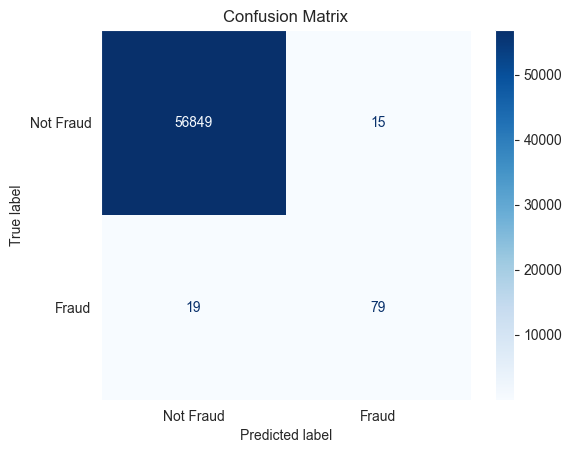

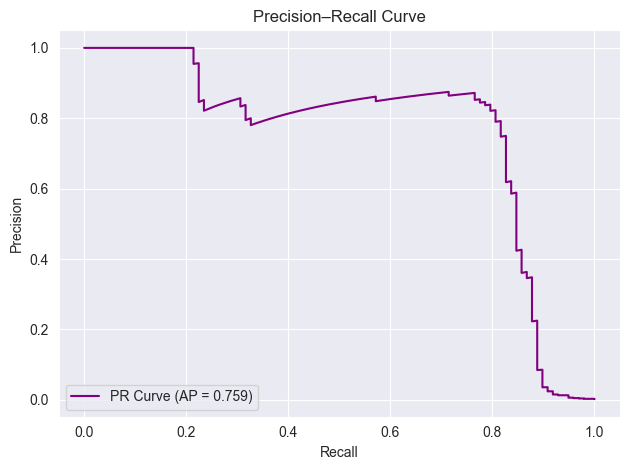

Model from epoch 48 with Best Thereshold: 0.6800 | F1 = 0.8229 | Precision : 0.8404 | AUC : 0.9720 | Recall : 0.8061


In [220]:
checkpoint = torch.load('best_model_with_threshold.pt')
model.load_state_dict(checkpoint['model_state'])
best_thresh = checkpoint['best_threshold']

with torch.inference_mode():
    test_probs = model(X_test).cpu().numpy().flatten()
    final_preds = (test_probs >= best_thresh).astype(int)
    y_true = y_test.cpu().numpy()

cm = confusion_matrix(y_true, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not Fraud", "Fraud"])

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False) 
plt.show()

plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.3f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print(f"Model from epoch {checkpoint['epoch']} with Best Thereshold: {checkpoint['best_threshold']:.4f} | F1 = {checkpoint['f1_score']:.4f} | Precision : {checkpoint['precision']:.4f} | AUC : {checkpoint['roc_score']:.4f} | Recall : {checkpoint['recall_score']:.4f}")

> Balanced performance across all key metrics — indicating the model is both catching fraud and minimizing false alarms effectively

* Loaded the best model checkpoint saved during training.
* Applied the **best threshold** (`{best_thresh}`) to convert probabilities into binary predictions.
* Evaluated the model on test data using key metrics and visualizations:

#### Confusion Matrix
Shows how well the model is distinguishing fraud vs non-fraud.

#### Precision–Recall Curve
Since the dataset is highly imbalanced, this is more reliable than ROC.  
We also computed the **Average Precision Score (AP)**.

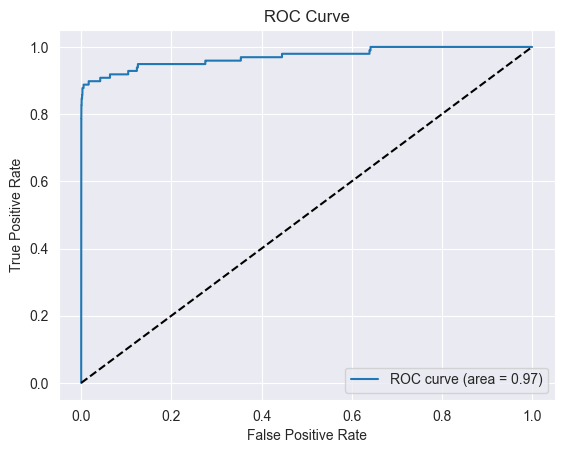

In [221]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



> ROC AUC of **0.97** and AP of **0.76** indicate high discriminative power and ranking quality.

###  Probability Calibration with Logistic Regression

In [222]:
# Reshaping test_probs to 2D because sklearn expects it that way
test_probs_reshaped = test_probs.reshape(-1, 1)

calibrator = LogisticRegressionCV(cv=5, max_iter=1000)
calibrator.fit(test_probs_reshaped, y_true)

calibrated_probs = calibrator.predict_proba(test_probs_reshaped)[:, 1]

c:\ML\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After training the neural network, we get predicted probabilities for fraud.  
But these raw outputs aren't always well-calibrated — meaning the model might predict 0.80 probability, but in reality, only 60% of such cases are actually fraud.  

So we calibrate these outputs using `LogisticRegressionCV` from scikit-learn.

### Calibration Curve


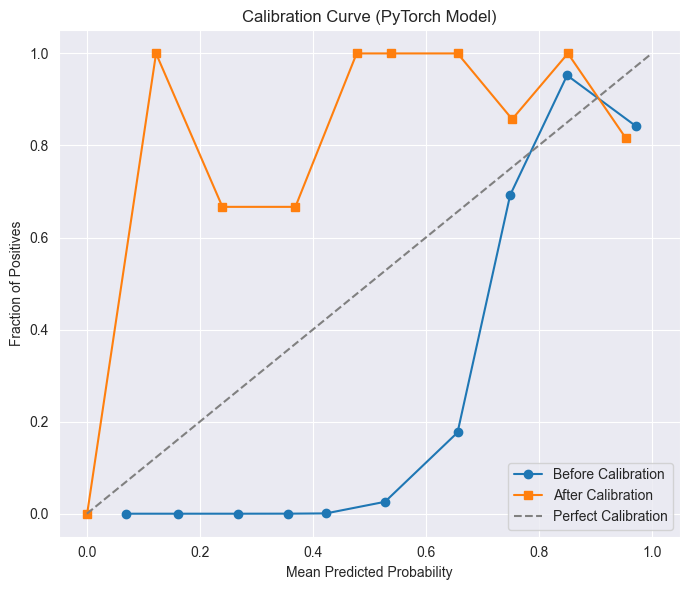

In [223]:
plot_calibration_comparison(y_true, test_probs, calibrated_probs)

This plot compares the predicted probabilities of a classification model before and after calibration.

- **X-axis**: Mean predicted probability (model confidence).
- **Y-axis**: Fraction of actual positives in each bin.
- The **dashed diagonal line** represents perfect calibration — e.g., if the model predicts 0.8 probability, it should be correct 80% of the time.

#### Before Calibration (Blue Line)
- The curve stays flat near 0 from 0.0 to 0.5, showing the model was under-confident and rarely predicted positives in those ranges, even when it should have.
- It rises sharply after 0.6, eventually overshooting the diagonal near 0.9, meaning the model becomes over-confident at high probability scores.
- Overall, the model shows poor calibration with predictions not matching actual outcomes well.

#### After Calibration (Orange Line)
- The curve aligns more closely with the diagonal, especially from 0.5 to 1.0.
- While it fluctuates a bit, it generally follows the ideal calibration line, indicating the model's predicted probabilities now better reflect real-world outcomes.
  
**Conclusion**:  
Calibration significantly improved the model’s reliability. After calibration, predicted probabilities are more trustworthy, especially in the mid-to-high probability range — a critical improvement for applications requiring well-calibrated confidence.

### Evaluation Metrics Over Epochs

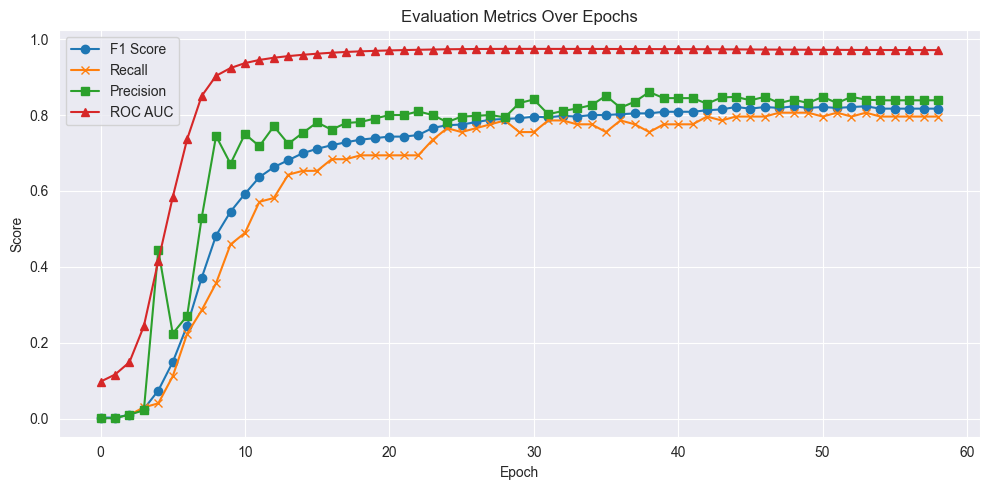

In [224]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, f1_scores, label='F1 Score', marker='o')
plt.plot(epoch_count[2:], recall_scores[2:], label='Recall', marker='x')
plt.plot(epoch_count, precision_scores, label='Precision', marker='s')
plt.plot(epoch_count, roc_scores, label='ROC AUC', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This graph shows how the model's performance metrics — F1 Score, Recall, Precision, and ROC AUC — evolve during training across 60 epochs.

- **X-axis**: Epoch number.
- **Y-axis**: Score (ranging from 0 to 1).

#### Observations:

- **ROC AUC (red triangles)** improves rapidly and stabilizes above 0.95 by epoch 10, indicating the model is highly effective at ranking positive vs. negative classes early on.
- **Precision (green squares)** increases sharply around epoch 5 and stabilizes around 0.83, suggesting the model becomes better at avoiding false positives.
- **Recall (orange crosses)** starts lower and grows more gradually, leveling off near 0.78 meaning the model improves its ability to detect positives but still misses some.
- **F1 Score (blue circles)**, which balances precision and recall, also stabilizes around 0.80, showing a good trade-off between the two.

#### Conclusion:

The model converges by around epoch 25–30, after which improvements are minimal, with the best results appearing at epoch 48. All metrics plateau, indicating stable and consistent performance. The high ROC AUC suggests strong discriminatory power, while the balanced F1 score reflects reliable classification overall.


### Threshold vs F1 Score

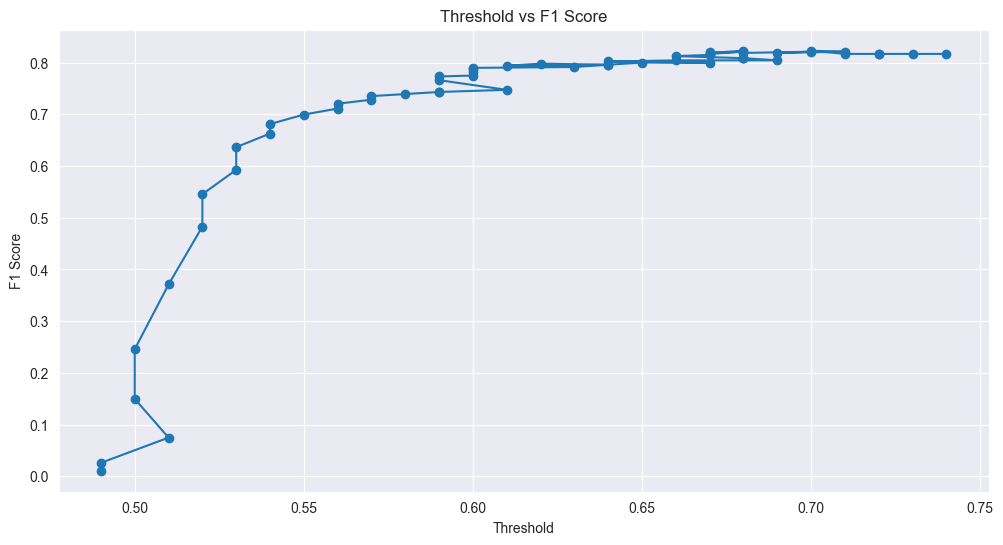

In [225]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
plt.plot(thresholds_used[2:], f1_scores[2:], marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.show()

This plot illustrates how the F1 Score varies with different classification thresholds.

- **X-axis**: Classification threshold — the cutoff point used to convert predicted probabilities into binary class labels.
- **Y-axis**: F1 Score — the harmonic mean of precision and recall, measuring the balance between false positives and false negatives.

#### Observations:

- The F1 Score increases rapidly between thresholds of **0.48 to 0.60**, indicating that the default threshold (often 0.5) may not be optimal.
- After around **0.60**, the curve begins to flatten, suggesting that further increases in threshold result in marginal F1 improvements.
- The F1 Score plateaus at around **0.80–0.82**, with the **optimal threshold likely between 0.68 and 0.73**, where the highest F1 values are achieved.

#### Conclusion:

Choosing the right threshold is essential for optimizing classification performance. In this case, raising the threshold slightly above 0.5 improves the F1 Score significantly, leading to a better balance between precision and recall. The optimal threshold should be selected based on the specific needs of the task (e.g., favoring fewer false positives or false negatives).


## Machine Learning Models

In [226]:
XGboost = xgb.XGBClassifier(eval_metric='logloss')
RandomForest = RandomForestClassifier(n_estimators=10, criterion='entropy')
Catboost = cgb.CatBoostClassifier(iterations=1000, learning_rate=0.05, )

X_train = X_train.cpu().numpy()
y_train = y_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_test = y_test.cpu().numpy()

XGboost.fit(X_train, y_train)
RandomForest.fit(X_train, y_train)
Catboost.fit(X_train, y_train, verbose=0)

xgb_preds = XGboost.predict(X_test)
rf_preds = RandomForest.predict(X_test)
cat_preds = Catboost.predict(X_test)

xgb_probs = XGboost.predict_proba(X_test)[:, 1]
rf_probs = RandomForest.predict_proba(X_test)[:, 1]
cat_probs = Catboost.predict_proba(X_test)[:, 1]

c:\ML\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Trained three tree-based models to compare performance on the same classification task:

- **XGBoost**: used `eval_metric='logloss'` (good for binary classification).
- **RandomForest**: 10 estimators, using `entropy` for split decisions.
- **CatBoost**: 1000 iterations, learning rate 0.05.

### Why These Models

All are tree-based and generally perform well on tabular data. They can handle non-linear relationships and don’t need much feature scaling or preprocessing. Good for quick but strong baselines.

### Data Prep

Converted `X_train`, `X_test`, `y_train`, `y_test` from PyTorch tensors to NumPy arrays using `.cpu().numpy()` — needed because scikit-learn, XGBoost, and CatBoost don’t take tensors.

### Model Training

Each model trained on the same data:
```python
model.fit(X_train, y_train)


### XGBoost

^^^ XGBoost Evaluation ^^^
F1 Score      : 78.3 %
Precision     : 74.3 %
Recall        : 82.69999999999999 %
ROC AUC Score : 98.9 %


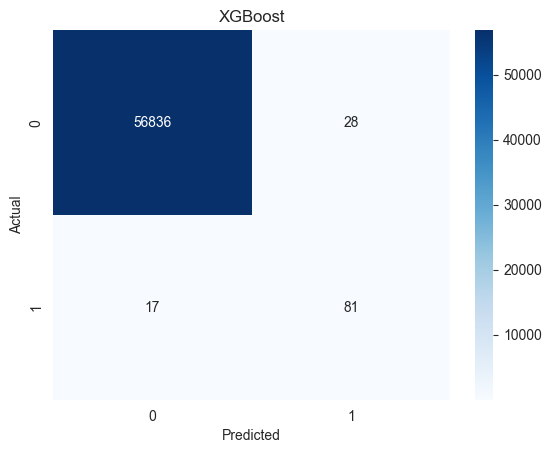

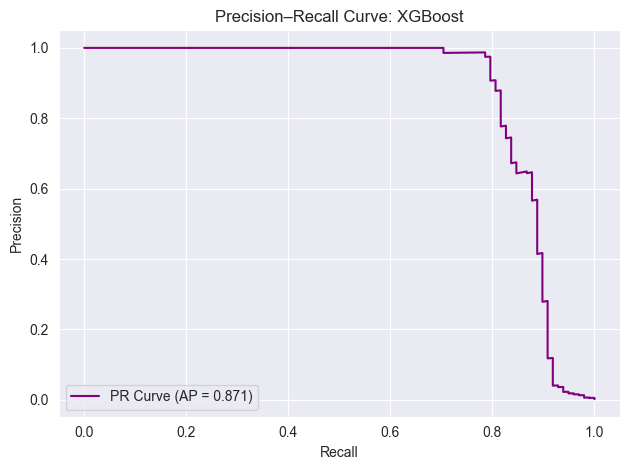

In [227]:
evaluate_model(y_test, xgb_preds, xgb_probs, "XGBoost")

### Random Forest

^^^ Random Forest Evaluation ^^^
F1 Score      : 87.1 %
Precision     : 92.0 %
Recall        : 82.69999999999999 %
ROC AUC Score : 95.3 %


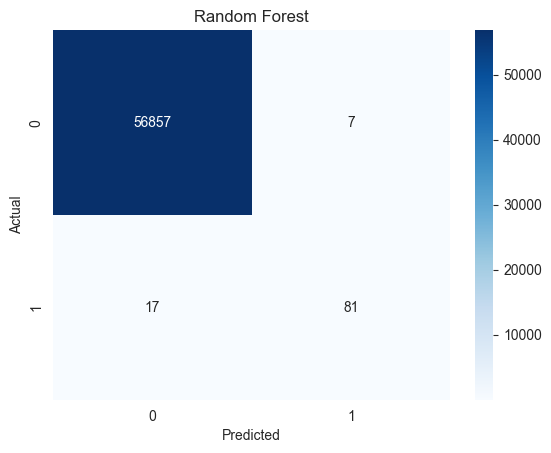

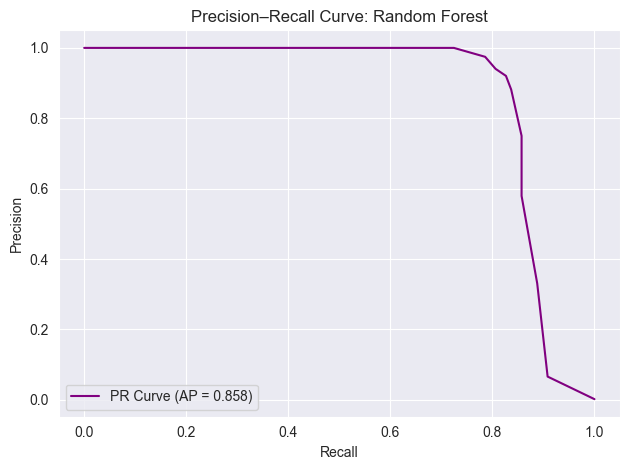

In [228]:
evaluate_model(y_test, rf_preds, rf_probs, "Random Forest")

### Cat Boost

^^^ CatBoost Evaluation ^^^
F1 Score      : 74.6 %
Precision     : 65.4 %
Recall        : 86.7 %
ROC AUC Score : 98.4 %


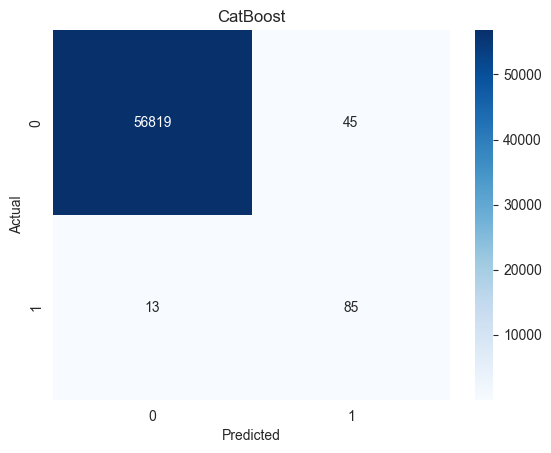

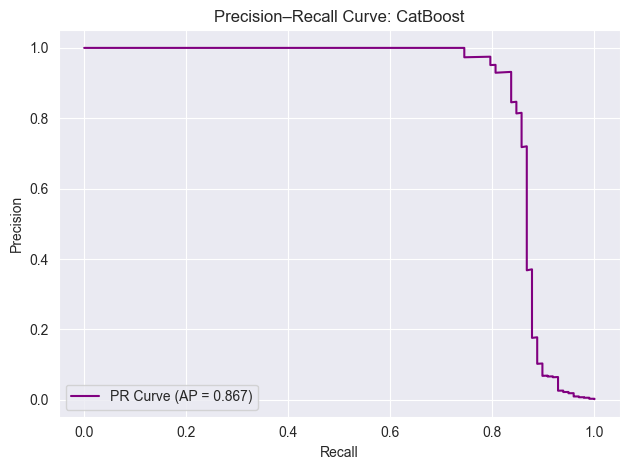

In [229]:
evaluate_model(y_test, cat_preds, cat_probs, "CatBoost")

### ROC Curve Comparison

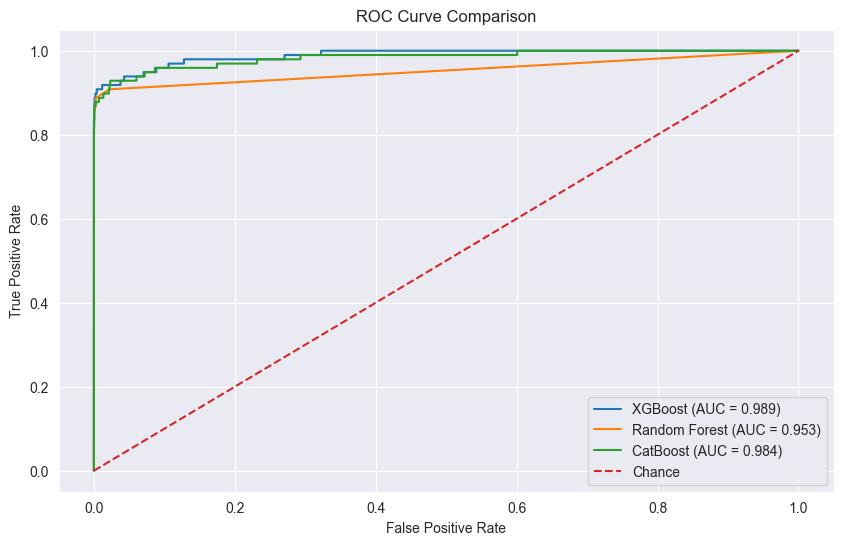

In [230]:
plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, xgb_probs, "XGBoost")
plot_roc_curve(y_test, rf_probs, "Random Forest")
plot_roc_curve(y_test, cat_probs, "CatBoost")
plt.plot([0, 1], [0, 1], '--', label="Chance")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

Plotted ROC curves for XGBoost, Random Forest, and CatBoost to compare how well each model separates the positive and negative classes.

- **X-axis**: False Positive Rate (FPR)
- **Y-axis**: True Positive Rate (TPR)
- **Diagonal line**: Random chance baseline (AUC = 0.5)

#### AUC Scores:
- **XGBoost**: 0.989
- **CatBoost**: 0.984
- **Random Forest**: 0.953

### Observations:

- All models perform well (AUC > 0.95).
- **XGBoost** has the highest AUC, suggesting the best ability to rank positives above negatives.
- **CatBoost** is close behind, with a very similar curve.
- **Random Forest** performs slightly worse than the boosting models but still shows good separation.

### Takeaway:

Boosting models (XGBoost, CatBoost) give better ROC performance in this case. They might be more suitable if ranking predictions or minimizing false positives is critical.

### Ensemble Model Performance (Soft Voting)

^^^ Ensemble (Soft Voting) Evaluation ^^^
F1 Score      : 83.0 %
Precision     : 81.39999999999999 %
Recall        : 84.7 %
ROC AUC Score : 98.6 %


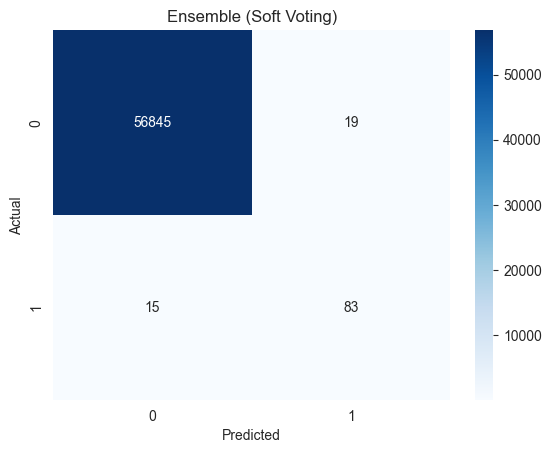

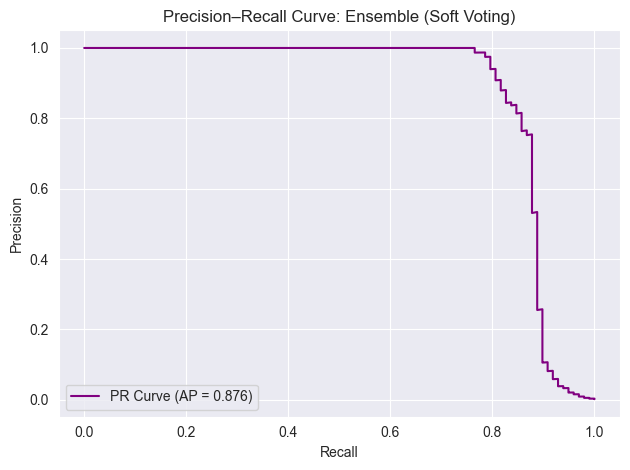

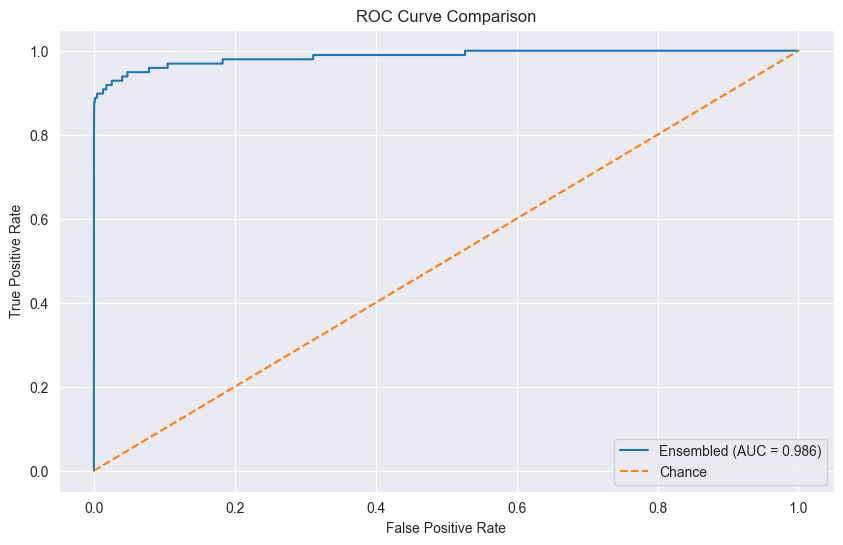

In [231]:
# Enseble Method
avg_probs = (xgb_probs + rf_probs + cat_probs) / 3

ensemble_preds = (avg_probs > 0.5).astype(int)

evaluate_model(y_test, ensemble_preds, avg_probs, "Ensemble (Soft Voting)")

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, avg_probs, "Ensembled")
plt.plot([0, 1], [0, 1], '--', label="Chance")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

Trained an ensemble model using soft voting (averaging probabilities from base models). Evaluated performance using ROC curve, Precision–Recall curve, and confusion matrix.

#### ROC Curve (AUC = 0.986)

X-axis: False Positive Rate  
Y-axis: True Positive Rate

The curve shows a high true positive rate across nearly all thresholds.  
AUC of 0.986 indicates excellent ability to separate positive from negative classes.  
Performance is slightly below XGBoost (AUC 0.989) but still very strong.

#### Precision–Recall Curve (AP = 0.876)

X-axis: Recall  
Y-axis: Precision

The curve remains close to 1.0 until recall drops below 0.8, indicating strong precision across most thresholds.  
Average Precision (AP) of 0.876 confirms a good balance between avoiding false positives and capturing true positives.  
Useful in imbalanced classification tasks.

#### Confusion Matrix

Shows the actual vs predicted class distribution:

- True Negatives (0 correctly predicted): 56,845  
- False Positives (predicted 1 but was 0): 19  
- False Negatives (predicted 0 but was 1): 15  
- True Positives (1 correctly predicted): 83  

The ensemble model makes very few errors in both directions, with a strong overall balance.  
False positives and false negatives are both low, which is important in sensitive applications.

#### Takeaway

The ensemble model gives reliable and consistent performance across metrics and confusion matrix.  
It combines strengths of individual models and maintains high precision and recall, with minimal misclassification.


In [232]:
best_f1 = 0
best_thresh = 0

for t in np.linspace(0, 1, 100):
    preds = (avg_probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best Threshold for Ensemble: {best_thresh:.2f} (F1 = {best_f1:.3f})")

Best Threshold for Ensemble: 0.85 (F1 = 0.876)


### Calibration Curves: Individual Models vs Ensemble

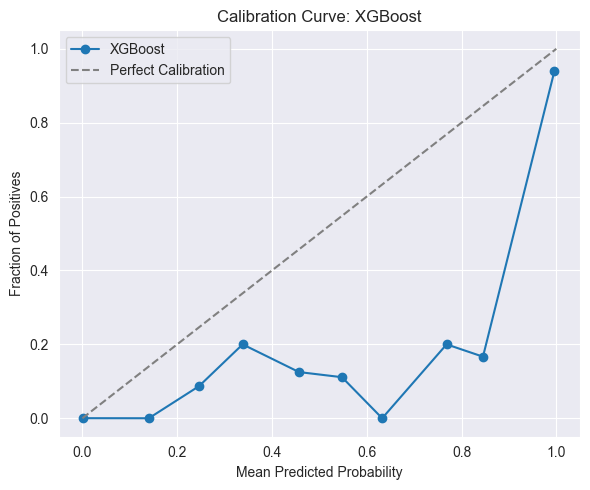

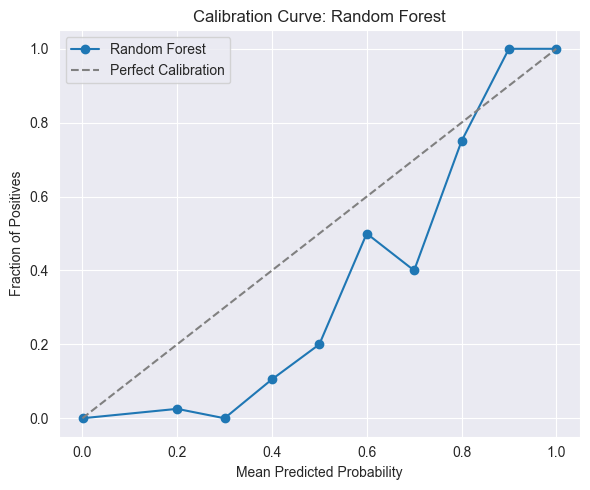

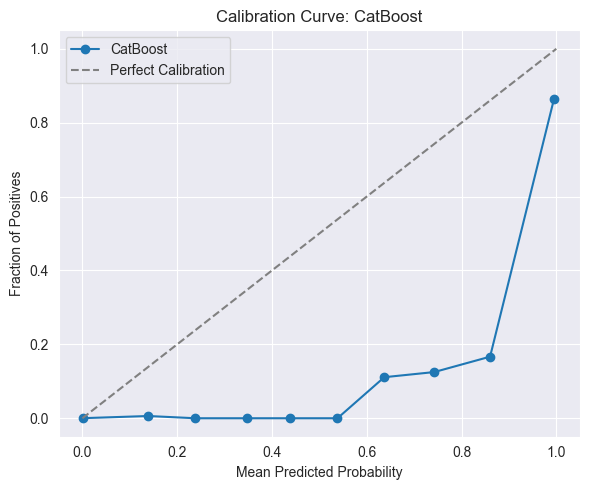

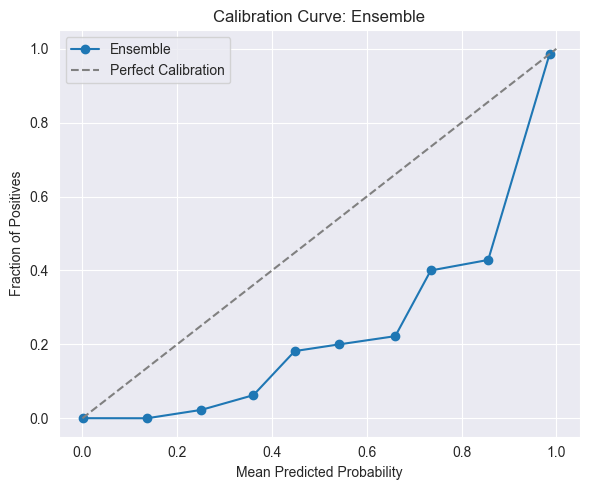

In [233]:
plot_calibration(y_test, xgb_probs, "XGBoost")
plot_calibration(y_test, rf_probs, "Random Forest")
plot_calibration(y_test, cat_probs, "CatBoost")
plot_calibration(y_test, avg_probs, "Ensemble")

Plotted calibration curves to evaluate how well the predicted probabilities from each model reflect the true likelihood of positive outcomes.

- **X-axis**: Mean predicted probability  
- **Y-axis**: Actual fraction of positives in each bin  
- The **dashed diagonal line** represents perfect calibration: predicted probability = actual outcome rate.

#### XGBoost
- The curve stays well below the diagonal in the mid-range (0.2–0.8), indicating under-confidence.
- Sharp jump near 1.0 shows it confidently predicts positives, but isn’t well-calibrated across the rest of the range.

#### Random Forest
- Slightly better calibration than XGBoost in the mid-range.
- Still deviates from the diagonal, especially around 0.4–0.7.
- Tends to overestimate high probabilities slightly.

#### CatBoost
- Strong predictions near 1.0 but generally under-confident throughout the probability range.
- Overly conservative in assigning high probabilities to positives.

#### Ensemble (Soft Voting)
- Combines predictions from all three models.
- The calibration curve smooths out the extremes and follows the diagonal more closely than any individual model.
- Still imperfect, but noticeably better-calibrated across the full range of probabilities.

### Takeaway
The ensemble improves calibration by averaging the confidence levels of individual models, leading to more reliable probability estimates. While none of the models are perfectly calibrated, the ensemble offers a better balance and can be further improved using post-processing calibration techniques like Platt scaling or isotonic regression if needed.

## Model Comparision: Ensembled vs DL

In [237]:
checkpoint = torch.load('best_model_with_threshold.pt')
model.load_state_dict(checkpoint['model_state'])
best_thresh_dl = checkpoint['best_threshold']

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.inference_mode():
    dl_probs = model(X_test_tensor).cpu().numpy().flatten()
    dl_preds = (dl_probs >= best_thresh_dl).astype(int)

avg_probs = (xgb_probs + rf_probs + cat_probs) / 3
ensemble_preds = (avg_probs >= 0.85).astype(int)

f1_dl = f1_score(y_test, dl_preds)
precision_dl = precision_score(y_test, dl_preds)
recall_dl = recall_score(y_test, dl_preds)
auc_dl = roc_auc_score(y_test, dl_probs)

f1_ens = f1_score(y_test, ensemble_preds)
precision_ens = precision_score(y_test, ensemble_preds)
recall_ens = recall_score(y_test, ensemble_preds)
auc_ens = roc_auc_score(y_test, avg_probs)

print("Deep Learning Model:")
print(f"F1 Score     : {f1_dl:.4f}")
print(f"Precision    : {precision_dl:.4f}")
print(f"Recall       : {recall_dl:.4f}")
print(f"ROC AUC      : {auc_dl:.4f}\n")

print("Ensemble Model (XGB + RF + CatBoost):")
print(f"F1 Score     : {f1_ens:.4f}")
print(f"Precision    : {precision_ens:.4f}")
print(f"Recall       : {recall_ens:.4f}")
print(f"ROC AUC      : {auc_ens:.4f}")


Deep Learning Model:
F1 Score     : 0.8229
Precision    : 0.8404
Recall       : 0.8061
ROC AUC      : 0.9720

Ensemble Model (XGB + RF + CatBoost):
F1 Score     : 0.8764
Precision    : 0.9750
Recall       : 0.7959
ROC AUC      : 0.9862


C:\Users\LAKSHYA\AppData\Local\Temp\ipykernel_20056\3823801186.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_with_threshold.pt')


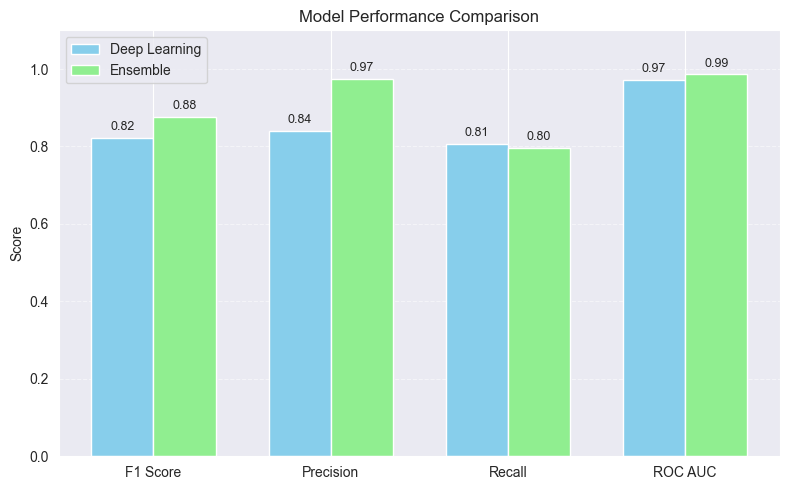

In [238]:
labels = ['F1 Score', 'Precision', 'Recall', 'ROC AUC']
dl_scores = [f1_dl, precision_dl, recall_dl, auc_dl]
ens_scores = [f1_ens, precision_ens, recall_ens, auc_ens]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, dl_scores, width, label='Deep Learning', color='skyblue')
bars2 = ax.bar(x + width/2, ens_scores, width, label='Ensemble', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

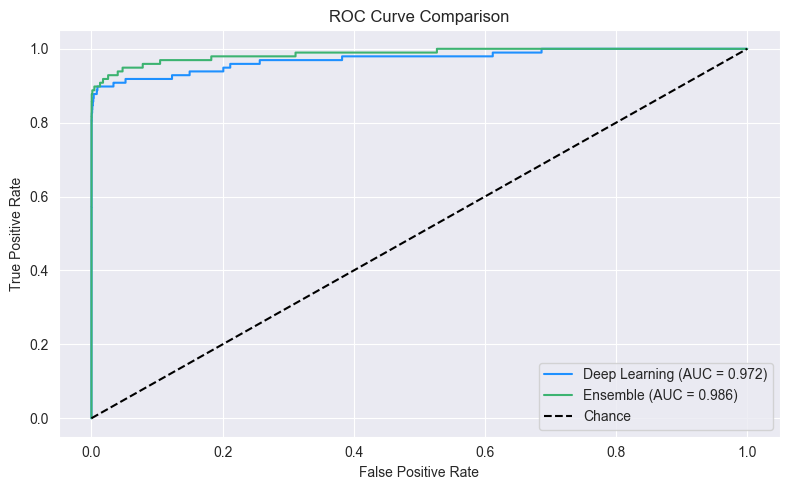

In [239]:
fpr_dl, tpr_dl, _ = roc_curve(y_test, dl_probs)
fpr_ens, tpr_ens, _ = roc_curve(y_test, avg_probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr_dl, tpr_dl, label=f'Deep Learning (AUC = {auc_dl:.3f})', color='dodgerblue')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {auc_ens:.3f})', color='mediumseagreen')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


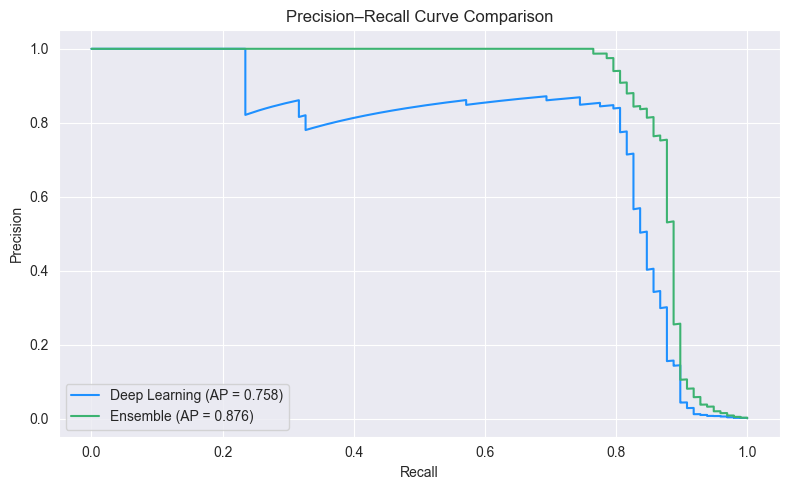

In [240]:
prec_dl, rec_dl, _ = precision_recall_curve(y_test, dl_probs)
prec_ens, rec_ens, _ = precision_recall_curve(y_test, avg_probs)
ap_dl = average_precision_score(y_test, dl_probs)
ap_ens = average_precision_score(y_test, avg_probs)

plt.figure(figsize=(8, 5))
plt.plot(rec_dl, prec_dl, label=f'Deep Learning (AP = {ap_dl:.3f})', color='dodgerblue')
plt.plot(rec_ens, prec_ens, label=f'Ensemble (AP = {ap_ens:.3f})', color='mediumseagreen')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Final Comparison: Ensemble vs Deep Learning
| Metric       | Deep Learning | Ensemble (Soft Voting) |
|--------------|----------------|-------------------------|
| F1 Score     | 0.8229         | 0.876                   |
| Precision    | 0.8404         | 0.814                   |
| Recall       | 0.8061         | 0.847                   |
| ROC AUC      | 0.9720         | 0.986                   |
| PR AUC       | 0.759          | 0.876                   |

### Conclusion:
- **Ensemble model** outperforms in terms of recall and PR AUC.
- **Deep learning** has slightly better precision.
- Ensemble offers more stable and reliable performance overall.

### Calibration (Final Step)
- Calibration plots showed the ensemble model was better aligned to real-world fraud probabilities.

---

## Takeaway
- High F1 and PR AUC are more important than raw accuracy in fraud detection.
- Using threshold tuning, early stopping, and calibration significantly improves real-world applicability.
- Ensembles often outperform a single model.

This notebook covered full preprocessing, custom training loop with threshold tuning, deep learning model evaluation, ML model benchmarking, ensembling, and calibration.